# Regression

**If you are a Colab user**

If you use Google Colab, you can uncomment the following cell to mount your Google Drive to Colab.
After that, Clab can read/write files and data in your Google Drive

please change the current directory to be the folder that you save your Notebook and
data folder. For example, I save my Colab files and data in the following location

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

#%cd /content/drive/MyDrive/Colab\ Notebooks

**Install new library statsmodels**

We will use scikit-learn for ML. https://scikit-learn.org/stable/

Using the installation command in the terminal (if your computer is a Linux system) or
other command-line interpreter application like Anaconda Prompt
(if your computer is a Windows system):

*conda install scikit-learn*

If you would like to install it from this notebook, you uncomment the following cell and execute it

In [2]:
#!pip3 install scikit-learn

So far, we have installed

- jupyter notebook
- numpy
- pandas
- scipy
- matplotlib
- seaborn
- scikit-learn

**Set up standards for the remainder of the notebook**

In [3]:
## import libraries and tools ##

import numpy as np # linear algebra
import pandas as pd # data processing and CSV file I/O

import scipy as sp # scientific and technical computing
from scipy import stats

import math

#from matplotlib import rcParams
import matplotlib.pyplot as plt # visualization
import seaborn as sns

# we primarily use sklearn in this model
import sklearn
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif, f_regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, Lasso, ElasticNet, ElasticNetCV

# to display multiple outputs in one cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Review and Understand the Dataset

Concrete compressive strength can be predicted by concrete attributes. In the following, we list the name, type, measurement unit, and a brief description, of concrete attributes and concrete compressive strength.

Name -- Data Type -- Measurement -- Description

- Cement -- quantitative -- kg in a m3 mixture -- Independent Variable
- Blast Furnace Slag -- quantitative -- kg in a m3 mixture -- Independent Variable
- Fly Ash -- quantitative -- kg in a m3 mixture -- Independent Variable
- Water -- quantitative -- kg in a m3 mixture -- Independent Variable
- Superplasticizer -- quantitative -- kg in a m3 mixture -- Independent Variable
- Coarse Aggregate -- quantitative -- kg in a m3 mixture -- Independent Variable
- Fine Aggregate -- quantitative -- kg in a m3 mixture -- Independent Variable
- Age -- quantitative -- Day (1~365) -- Independent Variable
- Concrete compressive strength -- quantitative -- MPa -- Response Variable
- Defect -- binary -- 1/0 -- Response Variable

In [4]:
## read the dataset in csv format ##
df = pd.read_csv('Data/Concrete_Data.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cement            1030 non-null   float64
 1   slag              1030 non-null   float64
 2   flyash            1030 non-null   float64
 3   water             1030 non-null   float64
 4   superplasticizer  1030 non-null   float64
 5   coarseaggregate   1030 non-null   float64
 6   fineaggregate     1030 non-null   float64
 7   age               1030 non-null   int64  
 8   csMPa             1030 non-null   float64
 9   dft               1030 non-null   int64  
dtypes: float64(8), int64(2)
memory usage: 80.6 KB


,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa,dft
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99,0
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89,0
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27,0
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05,0
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30,0


In [5]:
## count duplicated rows and determine if we would like to drop them
df.duplicated().sum() # there are 25 rows duplicating others

df=df.drop_duplicates() # drop duplicated rows

np.int64(25)

## Splitting dataset into training data and test data

In [6]:
# separate the predictors X from the response y
X = df.iloc[:,:-2] # all columns except for the last two columns
Y = df.iloc[:,-2:] # the last two columns are the response variables

In [7]:
## split the dataset into training and testing datasets using a 80%-20% randomized split.##
## train_test_split (X, y, test_size, random_state) in sklearn can be used for this purpose##
random_state = 15 # select a specific random_state to ensure the result is reproducable
X_train, X_test, Y_train, Y_test = train_test_split(X, 
                                                    Y, 
                                                    test_size = 0.2, 
                                                    random_state=random_state
                                                   )

In [8]:
# separate the two response variables: compresive strength response (str) and defective condition (dft)
y_str_train, y_dft_train = Y_train.values[:,0], Y_train.values[:,1]
y_str_test, y_dft_test = Y_test.values[:,0], Y_test.values[:,1]

In [10]:
# dimensions of train and test sets
N = df.shape[1]-2
print(f'The number of attributes: {N}\n')

M = Y_train.shape[0]
print(f'The number of data points in training set: {M}\n')

L = Y_test.shape[0]
print(f'The number of data points in test set: {L}\n')

The number of attributes: 8

The number of data points in training set: 804

The number of data points in test set: 201



## Data Normalization

Predictors are heterogeneous in that they are in vary different magnitude. We normalize the data so that some variables do not dominate others.

In [9]:
# We can use the provided features as predictors. 
#Fr_train = X_train.values
#Fr_test = X_test.values

# We can also modify the provided feature data to improve their ability to predict the resposne.

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Fr_train = scaler.fit_transform(X_train)
Fr_test = scaler.fit_transform(X_test)

## Define metrics for evaluating goodness-of-fit

In [11]:
# assembly model overall goodness-of-fit metrics on training data
def print_selection(model, Fr, Y, M, N, rsp_type="numr"):
    # rsp_type: default value is "numr" - numerical response. "cgtr" - categorical response

    if rsp_type=="numr":
        #LogL = (-M/2*np.log(2*np.pi)-M*np.log(np.sqrt(metrics.mean_squared_error(Y, model.predict(Fr))))-(M-N-1)/2)
        #AIC = -2*LogL+2*(1+N)
        #BIC = -2*LogL+np.log(M)*(1+N)
        r2_train = cross_val_score(model, Fr, Y, cv =5, scoring = 'r2').mean()
        #adj_r2_train = 1 - (1 - r2_train) * ((M - 1) / (M - N - 1))
        #print(f"AIC:{AIC:,.0f}")
        #print(f"BIC:{BIC:,.0f}")
        print(f'The average R squared value for training: {r2_train*100 :.2f}%')
        #print(f'The average adjusted R squared value for training: {adj_r2_train*100 :.2f}%')
    
    elif rsp_type=="cagr":
        acc_train = cross_val_score(model, Fr, Y, cv =5, scoring = 'accuracy').mean()
        print(f'The average accuracy for training: {acc_train*100 :.2f}%')
    
    else:
        print('wrong type: {numr: numerical, cagr: categorical} ')


In [12]:
# assembly model performance metrics together
def print_evaluate(true, predicted, rsp_type="numr"):
# rsp_type: default value is "numr" - numerical response. "cgtr" - categorical response
    from sklearn import metrics
    from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve
    
    if rsp_type=="numr":
        mae = metrics.mean_absolute_error(true, predicted)
        mse = metrics.mean_squared_error(true, predicted)
        rmse = np.sqrt(mse)
        r_squared = metrics.r2_score(true, predicted)
        #return mae, mse, rmse, r2_square
        print(f'MAE: {mae:.2f}')
        print(f'MSE: {mse:.2f}')
        print(f'RMSE: {rmse:.2f}')
        print(f'R Squared: {r_squared*100:.2f}%')
        print('__________________________________')
        
    elif rsp_type=="cagr":
        cls_report = metrics.classification_report(true, predicted)
        acc = metrics.accuracy_score(true, predicted)
        print(f'classification accuracy: {acc*100:.2f}%')
        print(f'classification report:{cls_report}\n')

        class_names = np.unique(true).astype(str).tolist()
        fig, ax = plt.subplots(figsize=(5,3))
        tick_marks = np.arange(len(class_names))
        cm = confusion_matrix(true,predicted)
        sns.heatmap(pd.DataFrame(cm), 
                    annot=True, 
                    cmap="YlGnBu" ,
                    fmt='g',
                    xticklabels=class_names,
                    yticklabels=class_names)
    
        ax.xaxis.set_label_position("top")
    
        plt.tight_layout()
        plt.title('Confusion matrix', y=1.1)
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show();
    else:
        print('wrong type: "numr"-numerical, "cagr"-categorical')

## Ordinary Linear Regression Model

In [13]:
# call the linear regressor and fit the linear regression model

lr_model = LinearRegression().fit(Fr_train,y_str_train)

In [14]:
# define coefficient names
Coef_names = [f"w{i}" for i in range(N+1)]
Coef_names

['w0', 'w1', 'w2', 'w3', 'w4', 'w5', 'w6', 'w7', 'w8']

In [15]:
# regression coefficients, w0, w1,..., w8
coeff_df = pd.DataFrame(np.append(lr_model.intercept_,lr_model.coef_), 
                        index = Coef_names,
                        columns = ['Coefficient'])
coeff_df.round(3)

,Coefficient
w0,35.666
w1,12.299
w2,9.007
w3,5.701
w4,-3.052
w5,1.849
w6,1.459
w7,1.411
w8,7.245


In [16]:
## We can also find regression coefficients using linear algebra
Z = np.append(np.ones([M,1]),Fr_train,1)  # eq.(9)
w_hat = np.linalg.inv(Z.T @ Z) @ Z.T @ y_str_train  # eq.(16)
coef_lr = pd.DataFrame(w_hat,
                       index = Coef_names,
                       columns=['Coefficient'])
coef_lr.round(3)

,Coefficient
w0,35.666
w1,12.299
w2,9.007
w3,5.701
w4,-3.052
w5,1.849
w6,1.459
w7,1.411
w8,7.245


In [17]:
# We can also provide the interval estimates for the coefficients 

# calculate standard errors of regression efficients using linear algebra
residuals = y_str_train - lr_model.predict(Fr_train)
residual_sum_of_squares = residuals.T @ residuals
sigma_squared_hat = residual_sum_of_squares / (M-N-1) # this is the point estimate of sigma_epsilon^2. see eq.(19)

var_w_hat =np.linalg.inv(Z.T @ Z)*sigma_squared_hat # eq.(21)

se = np.sqrt(np.diag(var_w_hat)) #eq.(22)

# determine the t-value
from scipy.stats import t
alpha = 0.05 # level of significance. You can change to your own value
t_val = t(M-N-1).ppf(1-alpha/2) # t-value at 1-alpha/2

# margin of error
me = se * t_val #eq.(23)

In [18]:
# display the (1-alpha) confidence interval estimates for regression coefficients w0, w1,..., w8
lr_coefficients_CI=pd.DataFrame(np.append(w_hat.reshape(N+1,1),me.reshape(N+1,1),1),
                                index = Coef_names,
                                columns=['Coefficient','Margin of error'])
print(f'the {1-alpha} interval estimates for the regression coefficients are:\n')
lr_coefficients_CI.round(3)

# the 95% interval estimates for w1 and w2 constains zero, indicating C1 and C2 might not be useful predictors 

the 0.95 interval estimates for the regression coefficients are:



,Coefficient,Margin of error
w0,35.666,0.722
w1,12.299,1.980
w2,9.007,1.947
w3,5.701,1.781
w4,-3.052,1.908
w5,1.849,1.214
w6,1.459,1.611
w7,1.411,1.890
w8,7.245,0.766


<Figure size 1200x300 with 0 Axes>

Text(0.5, 0, 'observations')

Text(0, 0.5, 'residuals')

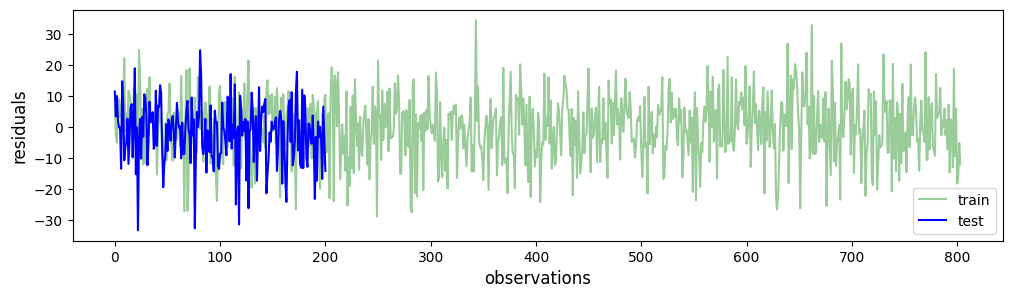

In [19]:
# visually check independence of residuals
# independence of residuals seems to hold

plt.figure(figsize=(12,3))
plt.plot(y_str_train-lr_model.predict(Fr_train),c='g',alpha=0.4) # residual calculated using the training dataset
plt.plot(y_str_test-lr_model.predict(Fr_test),c='b') # residual calculated using the testing dataset
plt.xlabel('observations',fontsize=12)
plt.ylabel('residuals',fontsize=12)
plt.legend(['train','test'])
plt.show()

(array([0.00373456, 0.00766568, 0.01434858, 0.03184205, 0.03439728,
        0.0369525 , 0.01886936, 0.00825535, 0.00157245, 0.00039311]),
 array([-28.83260125, -22.50472564, -16.17685003,  -9.84897443,
         -3.52109882,   2.80677679,   9.1346524 ,  15.46252801,
         21.79040361,  28.11827922,  34.44615483]),
 <BarContainer object of 10 artists>)

(array([0.00257175, 0.003429  , 0.006858  , 0.01971675, 0.03514725,
        0.03857625, 0.03857625, 0.020574  , 0.0051435 , 0.0017145 ]),
 array([-33.28595664, -27.48237096, -21.67878527, -15.87519959,
        -10.07161391,  -4.26802822,   1.53555746,   7.33914314,
         13.14272883,  18.94631451,  24.74990019]),
 <BarContainer object of 10 artists>)

Text(0.5, 0, 'residual')

Text(0, 0.5, 'pdf')

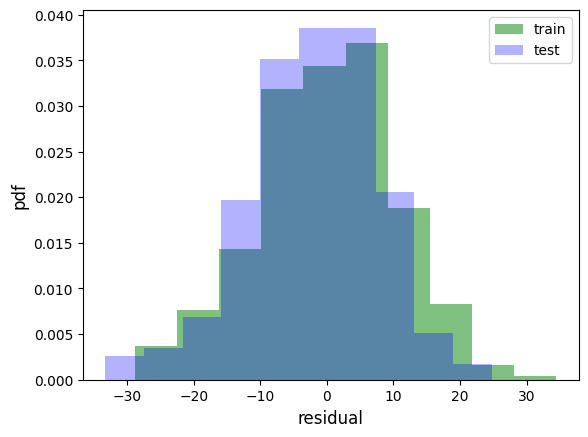

In [20]:
# examine the distribution of residuals
# the nomality of redisuals seems to hold

plt.hist(y_str_train-lr_model.predict(Fr_train),density=True,color='g',alpha=0.5) # distribution of residuals - training dataset
plt.hist(y_str_test-lr_model.predict(Fr_test),density=True,color='b',alpha=0.3) # distribuition of residuals - testing dataset
plt.legend(['train','test'])
plt.xlabel('residual',fontsize=12)
plt.ylabel('pdf',fontsize=12)
plt.show()

Text(0.5, 0, 'True Response')

Text(0, 0.5, 'Predicted Response')

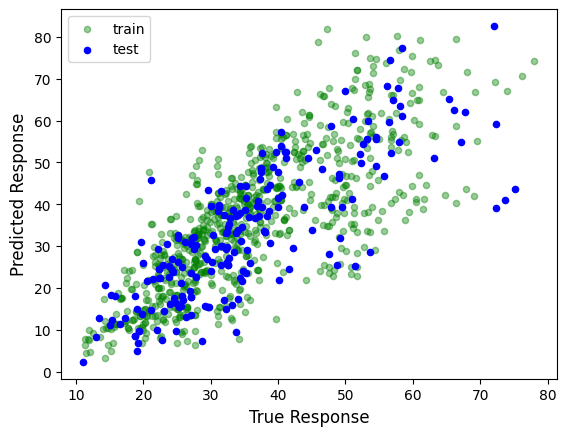

In [21]:
# show the correlation between predicted response and true response

plt.scatter(lr_model.predict(Fr_train),y_str_train,c='g',s=20,alpha=0.4) # true vs. prediction - training dataset
plt.scatter(lr_model.predict(Fr_test),y_str_test,c='b',s=20) # # true vs. prediction - testing dataset
plt.xlabel('True Response',fontsize=12)
plt.ylabel('Predicted Response',fontsize=12)
plt.legend(['train','test'])
plt.show()

Text(0.5, 0, 'predicted response')

Text(0, 0.5, 'residual')

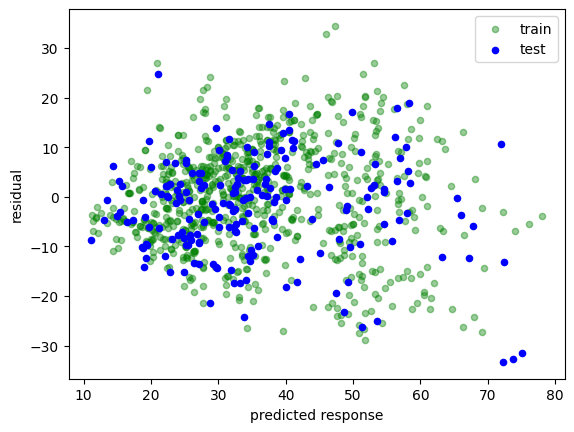

In [22]:
# residual against predicted response to check the homogeneity of residuals
plt.scatter(lr_model.predict(Fr_train), y_str_train-lr_model.predict(Fr_train),c='g',s=20,alpha=0.4)  # residual vs. prediction - training dataset
plt.scatter(lr_model.predict(Fr_test), y_str_test-lr_model.predict(Fr_test),c='b',s=20) # residual vs. prediction -testing dataset
plt.legend(['train','test'])
plt.xlabel('predicted response')
plt.ylabel('residual')
plt.show()

In [23]:
# overall goodness-of-fit in training 
print_selection(lr_model, Fr_train, y_str_train, M, N)

The average R squared value for training: 56.41%


In [24]:
# evaluate the model performance on the testing dataset
print_evaluate(y_str_test, lr_model.predict(Fr_test))

MAE: 7.62
MSE: 99.14
RMSE: 9.96
R Squared: 61.57%
__________________________________


In [25]:
# Univariate feature selection works by selecting the best features based on univariate statistical tests. 
# It can be seen as a preprocessing step to an estimator.
# SelectBest (metric, k) selects features according to the k highest scores.
FeatureSelection = SelectKBest(f_regression, k=6)
Fr_train_sel=FeatureSelection.fit_transform(Fr_train, y_str_train) # selected features
Sel_Index=FeatureSelection.get_support() # Boolean index indicating the selection
#Sel_Index=[False, True, True, True, True, True,True,True] #mannually override the selection result
print('Selected features are:\n',Sel_Index,'\n')

Fr_train_sel=Fr_train[:,Sel_Index]

# selected features in test dataset
Fr_test_sel = Fr_test[:,Sel_Index]

n = np.sum(Sel_Index) # the number of attributes

# fit the model using selected features
lr_model_new = LinearRegression().fit(Fr_train_sel, y_str_train)


# evaluate the goodness-of-fit of the regression model in training 
print('\nThe model overall goodness-of-fit in training is:')
print_selection(lr_model_new, Fr_train_sel, y_str_train, M, n)


print('\nThe test accuracy is:')
print_evaluate(y_str_test, lr_model_new.predict(Fr_test_sel))

Selected features are:
 [ True False False  True  True  True  True  True] 


The model overall goodness-of-fit in training is:
The average R squared value for training: 51.70%

The test accuracy is:
MAE: 7.99
MSE: 105.10
RMSE: 10.25
R Squared: 59.25%
__________________________________


## Binary Logistic Regression

We fit a binary logistic regression to predict if a concrete block will develop defect after one year of use by using the extracted PCs as the predictors

In [26]:
# let's check if classes are unbalanced. If it is unbalanced, we may consider
# using class weights in defining the loss function
uniqueVals, counts = np.unique(y_dft_train,return_counts=True)
print(f'The sizes for the classes {uniqueVals} are:{counts}\n')
print(counts)

The sizes for the classes [0. 1.] are:[575 229]

[575 229]


In [27]:
# fit a logistic regression model
blr_model=LogisticRegression(
    class_weight={0:1,1:1.5},
    solver='sag'
).fit(Fr_train,y_dft_train) # if use cross-entropy loss, multi-class='multinomial'


In [28]:
# regression coefficients
coeff_blr = pd.DataFrame(np.append(blr_model.intercept_,blr_model.coef_), 
                         index = Coef_names, 
                         columns = ['Coefficient'])
coeff_blr.round(3)

,Coefficient
w0,-3.253
w1,-2.235
w2,-1.385
w3,-0.555
w4,0.209
w5,-0.708
w6,-0.201
w7,-0.220
w8,-6.384


In [29]:
# training accuracy
print_selection(blr_model, Fr_train, y_dft_train, M, N,"cagr")

The average accuracy for training: 88.55%


classification accuracy: 89.55%
classification report:              precision    recall  f1-score   support

         0.0       0.94      0.90      0.92       136
         1.0       0.81      0.88      0.84        65

    accuracy                           0.90       201
   macro avg       0.88      0.89      0.88       201
weighted avg       0.90      0.90      0.90       201




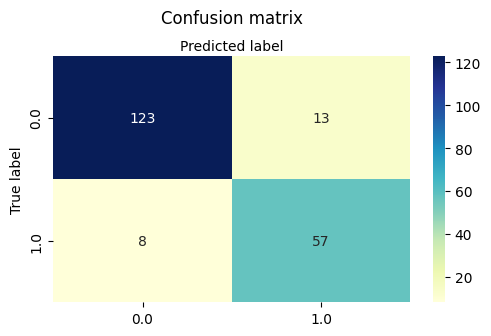

In [30]:
# regression model test performance 
print_evaluate(y_dft_test,blr_model.predict(Fr_test),"cagr")

In [31]:
# prediction on testing dataset
y_test_pred = blr_model.predict(Fr_test) #prediction of y_i's
p_test_pred = blr_model.predict_proba(Fr_test) # the probabilities that y_i is classes 0 and 1, respectively